In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, ZeroPadding2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


## 1. Data Overview

Reference Paper:    
Kather, Jakob Nikolas, et al. "Predicting survival from colorectal cancer histology slides using deep learning: A retrospective multicenter study." PLoS medicine 16.1 (2019): e1002730.

In [62]:
data = np.load('../datasets/pathmnist.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [63]:
x_train = data['train_images']
x_test = data['test_images']
x_val = data['val_images']

y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

In [64]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (89996, 28, 28, 3)
Shape of y_train: (89996, 1)
Shape of x_test: (7180, 28, 28, 3)
Shape of y_test: (7180, 1)
Shape of x_val: (10004, 28, 28, 3)
Shape of y_val: (10004, 1)


 The shapes indicate that the images have dimensions of 28x28 pixels, and this is a RGB image with 3 color channels.

In [65]:
unique_classes = np.unique(y_train)
print('The number of classes:', len(unique_classes))

The number of classes: 9


Class names:   
- ADI, adipose tissue;   
- BACK, background;   
- CRC, colorectal cancer;   
- DEB, debris;   
- HE, hematoxylin–eosin;    
- LYM, lymphocytes;    
- MUC, mucus;   
- MUS, smooth muscle; 
- NCT, National Center for Tumor Diseases; 
- NORM, normal colon mucosa;   
- STR, cancer-associated stroma;   
- TUM, colorectal adenocarcinoma epithelium.

In [66]:
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

In [67]:
class_data = {class_label: [] for class_label in unique_classes}
for class_label in unique_classes:
    class_idx = np.where(y_train == class_label)[0]
    class_data[class_label] = x_train[class_idx]

In [68]:
# Display the number of samples in each class
for class_label, class_samples in class_data.items():
    print(f"{class_names[class_label]}: {len(class_samples)} samples")

ADI: 9366 samples
BACK: 9509 samples
DEB: 10360 samples
LYM: 10401 samples
MUC: 8006 samples
MUS: 12182 samples
NORM: 7886 samples
STR: 9401 samples
TUM: 12885 samples


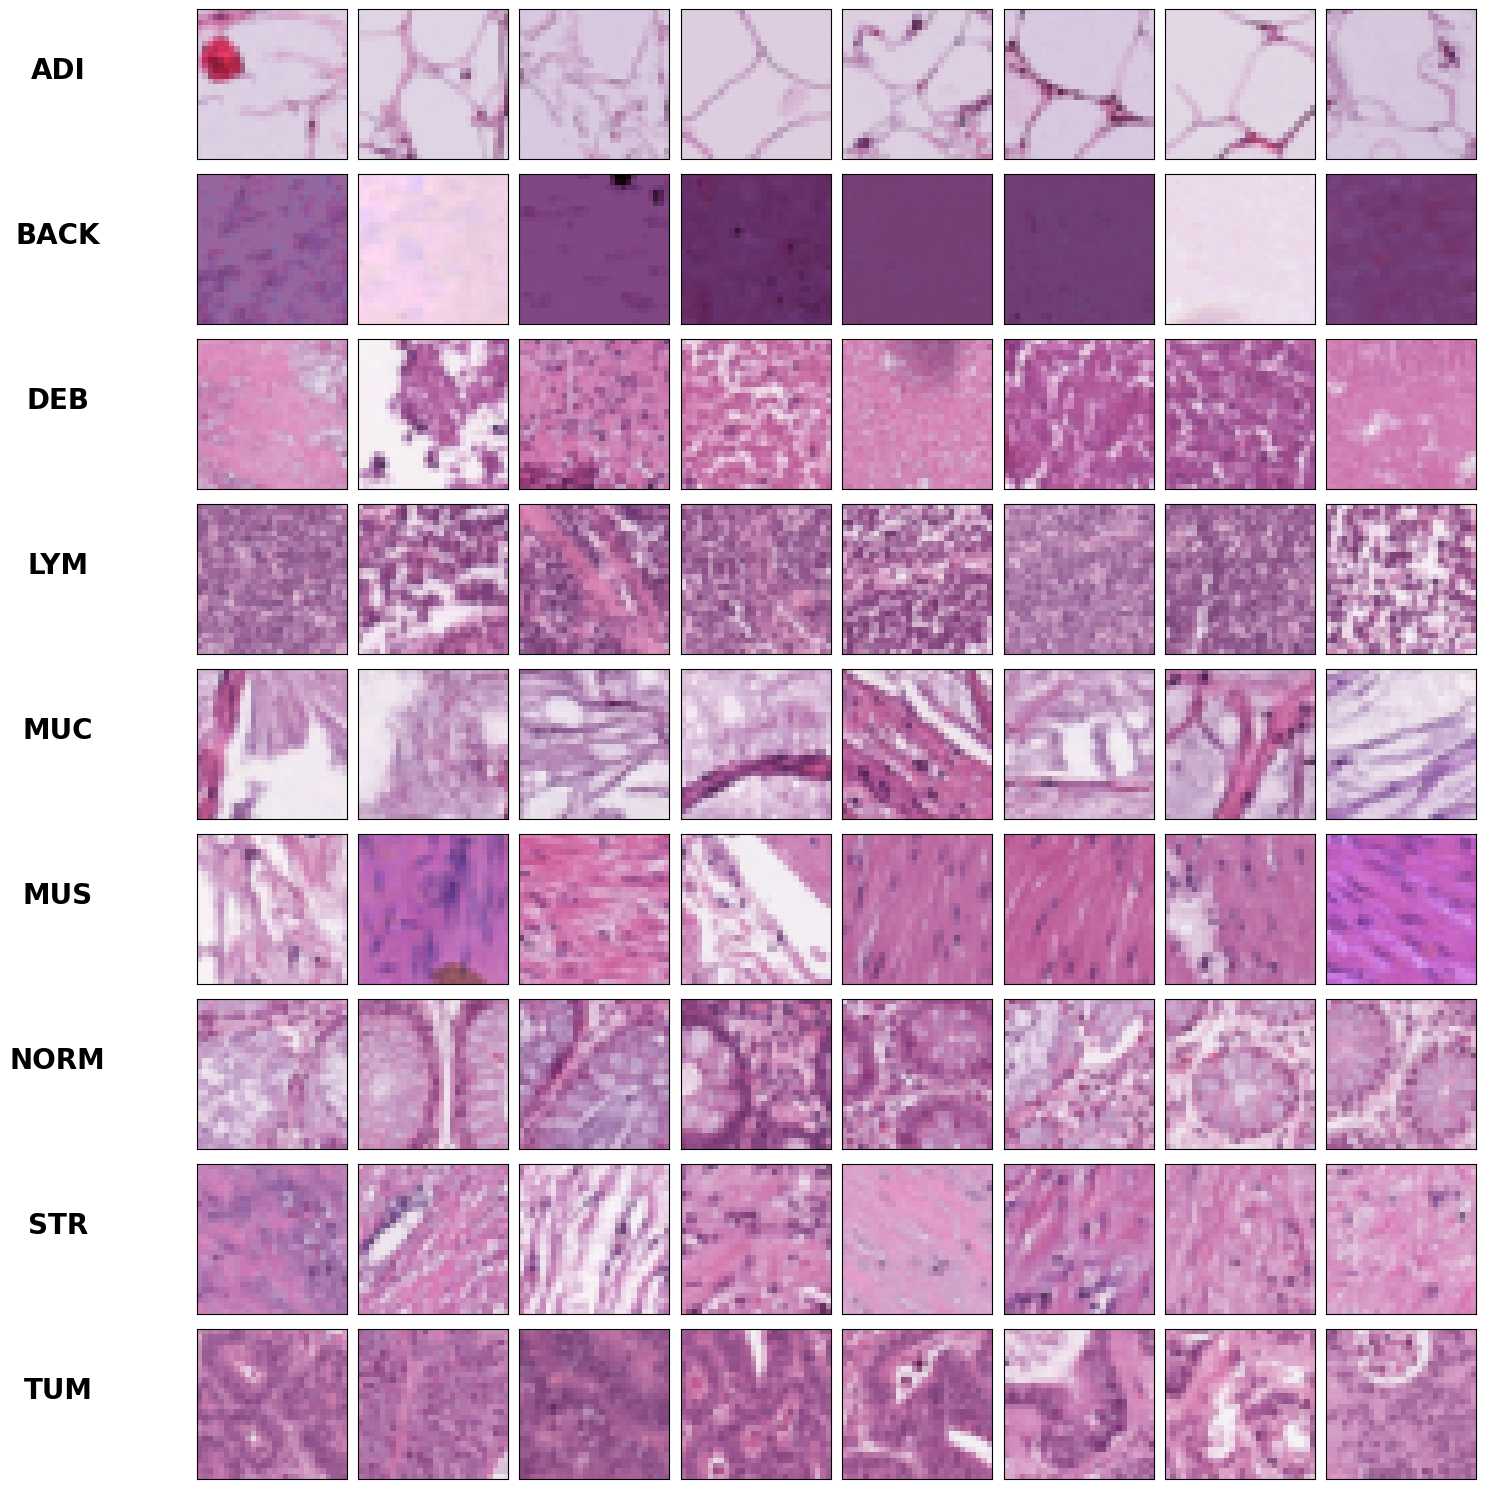

In [9]:
def imagedisplay(class_data, class_names, num_images_per_class):
    fig = plt.figure(figsize=(15, 15))
    
    for i, (class_label, class_samples) in enumerate(class_data.items()):
        np.random.shuffle(class_samples)
        class_samples = class_samples[:num_images_per_class]
        
        for j, img_data in enumerate(class_samples):
            fig.add_subplot(len(class_names), num_images_per_class, i * num_images_per_class + j + 1, 
                             xticks=[], yticks=[])
            
            plt.imshow(img_data)
            
            if j == 0:
                plt.ylabel(class_names[i], rotation=0, labelpad=100, fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

imagedisplay(class_data, class_names, 8)


In [62]:
def visualize_tsne(image_data, labels, class_names):
    image_data_flatten = image_data.reshape(image_data.shape[0], -1)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(image_data_flatten)

    tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
    tsne_df['Label'] = labels.astype(str)  # Convert labels to string for better handling in seaborn
    
    # Create a scatter plot using seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='tab10', alpha=0.7)

    plt.title("t-SNE Visualization of Image Clustering")
    plt.show()


d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\S

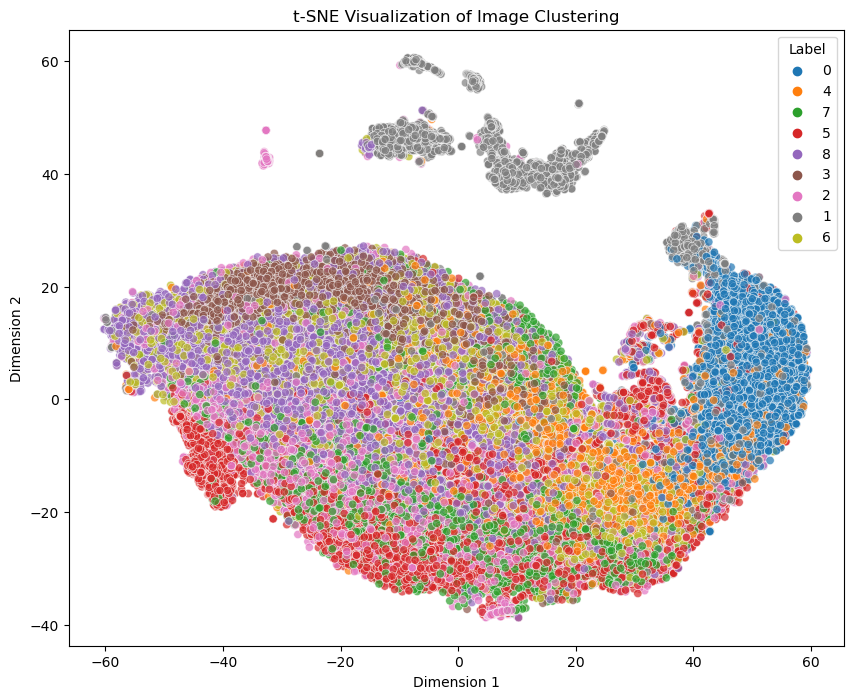

In [10]:
visualize_tsne(x_train, y_train, class_names)

## Data Preprocessing

In [69]:
x_train1 = np.array(x_train)/255
x_test1 = np.array(x_test)/255
x_val1 = np.array(x_val)/255
print(x_train1.shape)

(89996, 28, 28, 3)


In [70]:
# 3 flatten ways
x_train_flat = x_train1.reshape(x_train1.shape[0], -1)
x_test_flat = x_test1.reshape(x_test1.shape[0], -1)
x_val_flat =x_val.reshape(x_val1.shape[0], -1)
print(x_train_flat.shape)

(89996, 2352)


In [71]:
img_size = 28
x_train_flat = x_train.reshape(-1, img_size*img_size)
x_val_flat = x_val.reshape(-1, img_size* img_size)
x_test_flat = x_test.reshape(-1, img_size*img_size)
print(x_train_flat.shape)

(269988, 784)


In [72]:
x_train2 = x_train1.reshape(-1, img_size, img_size, 1)
x_val2 = x_val1.reshape(-1, img_size, img_size, 1)
x_test2 = x_test1.reshape(-1, img_size, img_size, 1)
y_train2 = y_train.copy()
y_val2 = y_val.copy()
y_test2 = y_test.copy()
print(x_train_flat.shape)

(269988, 784)


Data Augmentation

In [73]:
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,     
        samplewise_center=False,             
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30, 
        zoom_range = 0.2,  
        width_shift_range=0.2, 
        height_shift_range=0.2,
        horizontal_flip = True,   
        vertical_flip=True) 

In [74]:
datagen.fit(x_train2)

In [75]:
#One hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_val_one_hot = to_categorical(y_val)

In [76]:
print(x_train1.shape, y_train_one_hot.shape) 

(89996, 28, 28, 3) (89996, 9)


## 3. Model Training --KNN/ SVM/ CNN

### KNN

In [77]:
# x_train1, x_test1(/255), y_train
def knn_classification(x_train, y_train, x_test, y_test, n_neighbors=3):

    # Reshape the data, (89996, 28, 28, 3)-->(89996, 2352)
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(x_train_flat, y_train.ravel())
    predictions = knn_classifier.predict(x_test_flat)

    # Evaluate the performance
    accuracy = accuracy_score(y_test.ravel(), predictions)
    classification_rep = classification_report(y_test.ravel(), predictions)
    confusion_mat = confusion_matrix(y_test.ravel(), predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat

In [78]:
accuracy, classification_rep, confusion_mat = knn_classification(x_train1, y_train, x_test1, y_test)

Accuracy: 35.14%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.78      1338
           1       0.22      1.00      0.36       847
           2       0.23      0.89      0.36       339
           3       0.04      0.00      0.00       634
           4       0.10      0.01      0.03      1035
           5       0.23      0.11      0.15       592
           6       0.29      0.01      0.02       741
           7       0.03      0.00      0.00       421
           8       0.77      0.30      0.43      1233

    accuracy                           0.35      7180
   macro avg       0.31      0.33      0.24      7180
weighted avg       0.41      0.35      0.30      7180


Confusion Matrix:
 [[913 399   0   0   6  16   0   0   4]
 [  0 847   0   0   0   0   0   0   0]
 [  0  11 303   0   0  24   0   1   0]
 [  2 621   2   1   0   2   1   0   5]
 [ 61 950   2   0  15   3   1   0   3]
 [  0  13 501   0   1  64   0  12   1]

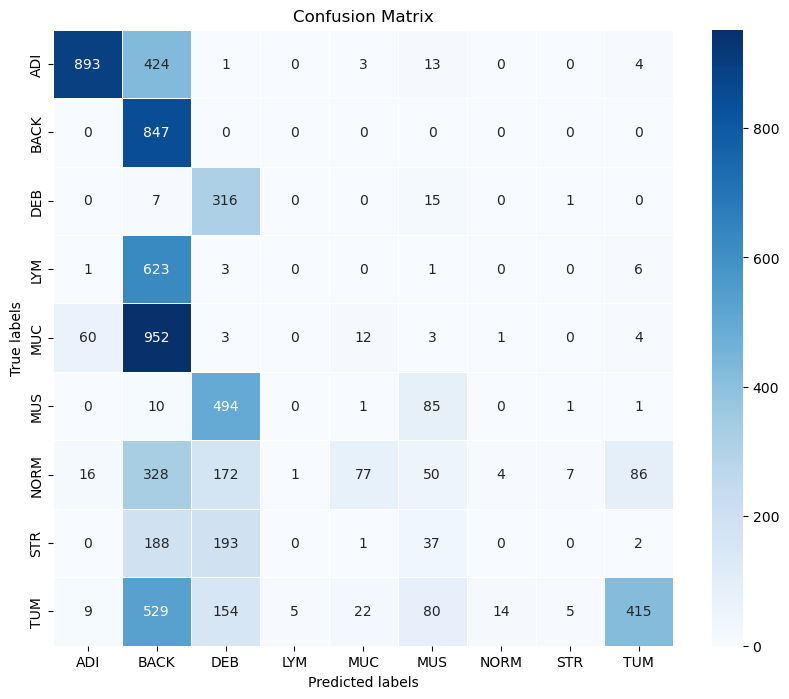

In [80]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g', linewidths=.5, annot_kws={"size": 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### SVM

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

def svm_classification(x_train, y_train, x_test, y_test, kernel='rbf', C=1.0, gamma='scale'):
    """
    Parameters:
    - x_train: Training data features
    - y_train: Training data labels
    - x_test: Testing data features
    - y_test: Testing data labels
    - kernel: Kernel type (default is 'rbf')
    - C: Regularization parameter (default is 1.0)
    - gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' (default is 'scale')

    Returns:
    - accuracy: Accuracy of the classifier on the test set
    - classification_rep: Classification report
    - confusion_mat: Confusion matrix
    """
    # Flatten and scale the data
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    # Scale the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)

    # Set the parameters for grid search
    param_grid = {'C': [5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4], 'gamma': ['auto']}

    # Initialize the SVM classifier with GridSearchCV
    clf = GridSearchCV(SVC(kernel=kernel), param_grid, cv=2, verbose=3)

    # Train the classifier
    clf.fit(x_train_scaled, y_train.ravel())

    # Make predictions on the test set
    predictions = clf.predict(x_test_scaled)

    # Get the best parameters found by grid search
    best_params = clf.best_params_
    print("Best parameters found by grid search:")
    print(best_params)

    # Evaluate the performance
    accuracy = accuracy_score(y_test.ravel(), predictions)
    classification_rep = classification_report(y_test.ravel(), predictions)
    confusion_mat = confusion_matrix(y_test.ravel(), predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat, best_params


In [ ]:
accuracy, classification_rep, confusion_mat = svm_classification(x_train1, y_train, x_test1, y_test)
# This runs 28 hours...

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .................C=5.0, gamma=auto;, score=0.687 total time=67.3min
[CV 2/2] END .................C=5.0, gamma=auto;, score=0.688 total time=65.9min
[CV 1/2] END ................C=10.0, gamma=auto;, score=0.683 total time=79.5min
[CV 2/2] END ................C=10.0, gamma=auto;, score=0.686 total time=75.1min
[CV 1/2] END ................C=50.0, gamma=auto;, score=0.673 total time=84.8min
[CV 2/2] END ................C=50.0, gamma=auto;, score=0.676 total time=85.8min
[CV 1/2] END ...............C=100.0, gamma=auto;, score=0.671 total time=87.3min
[CV 2/2] END ...............C=100.0, gamma=auto;, score=0.674 total time=87.6min
[CV 1/2] END ...............C=500.0, gamma=auto;, score=0.671 total time=87.2min
[CV 2/2] END ...............C=500.0, gamma=auto;, score=0.672 total time=87.4min
[CV 1/2] END ..............C=1000.0, gamma=auto;, score=0.671 total time=91.7min
[CV 2/2] END .............C=1000.0, gamma=auto;, 

ValueError: too many values to unpack (expected 3)

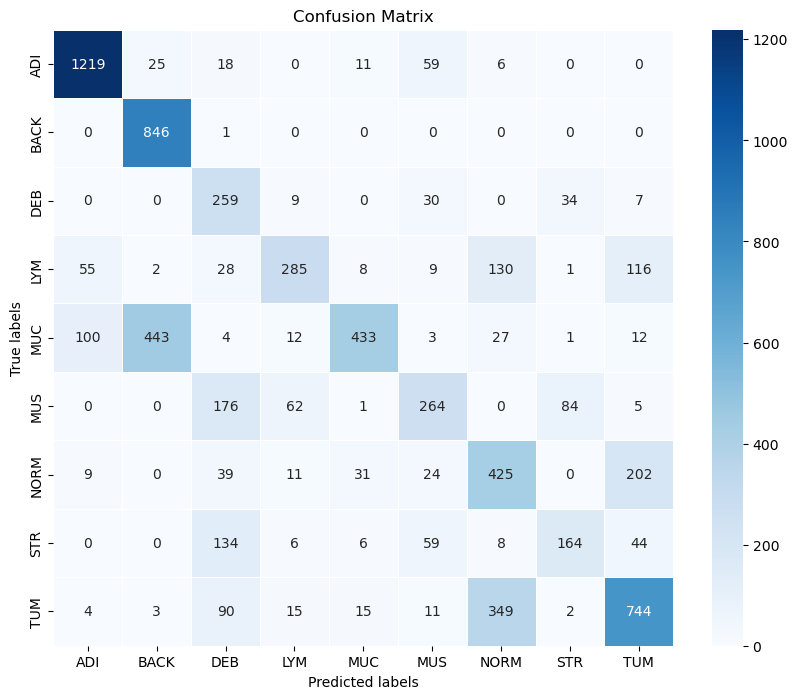

In [23]:
# Given confusion matrix
conf_matrix = np.array([[1219, 25, 18, 0, 11, 59, 6, 0, 0],
                        [0, 846, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 259, 9, 0, 30, 0, 34, 7],
                        [55, 2, 28, 285, 8, 9, 130, 1, 116],
                        [100, 443, 4, 12, 433, 3, 27, 1, 12],
                        [0, 0, 176, 62, 1, 264, 0, 84, 5],
                        [9, 0, 39, 11, 31, 24, 425, 0, 202],
                        [0, 0, 134, 6, 6, 59, 8, 164, 44],
                        [4, 3, 90, 15, 15, 11, 349, 2, 744]])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', linewidths=.5, annot_kws={"size": 10}, xticklabels=class_names, yticklabels = class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## CNN

In [47]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))


# Flatten and Fully Connected layers
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=9, activation='sigmoid'))

# Compile the model
model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_49 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_41 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_50 (Bat  (None, 14, 14, 64)      

In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [51]:
history = model.fit(x_train1, y_train_one_hot, epochs=10, validation_data=(x_val1, y_val_one_hot), callbacks=[learning_rate_reduction])

Epoch 1/10
2813/2813 [==============================] - 96s 34ms/step - loss: 0.0939 - accuracy: 0.8357 - val_loss: 0.1012 - val_accuracy: 0.8127 - lr: 2.7000e-04
Epoch 2/10
2813/2813 [==============================] - 105s 37ms/step - loss: 0.0933 - accuracy: 0.8373 - val_loss: 0.0825 - val_accuracy: 0.8652 - lr: 2.7000e-04
Epoch 3/10
2813/2813 [==============================] - 103s 36ms/step - loss: 0.0923 - accuracy: 0.8384 - val_loss: 0.1031 - val_accuracy: 0.8101 - lr: 2.7000e-04
Epoch 4/10
2813/2813 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.8386
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.099999686237424e-05.
2813/2813 [==============================] - 104s 37ms/step - loss: 0.0922 - accuracy: 0.8386 - val_loss: 0.0944 - val_accuracy: 0.8276 - lr: 2.7000e-04
Epoch 5/10
2813/2813 [==============================] - 103s 37ms/step - loss: 0.0916 - accuracy: 0.8408 - val_loss: 0.0965 - val_accuracy: 0.8214 - lr: 8.1000e-05
Epoch 6/10
2813/28

In [52]:
print("Test loss - " , model.evaluate(x_test1,y_test_one_hot)[0])
print("Test Accuracy - " , model.evaluate(x_test1,y_test_one_hot)[1]*100 , "%")

225/225 [==============================] - 2s 8ms/step - loss: 0.1081 - accuracy: 0.8358
Test loss -  0.10811854898929596
225/225 [==============================] - 2s 8ms/step - loss: 0.1081 - accuracy: 0.8358
Test Accuracy -  83.57938528060913 %


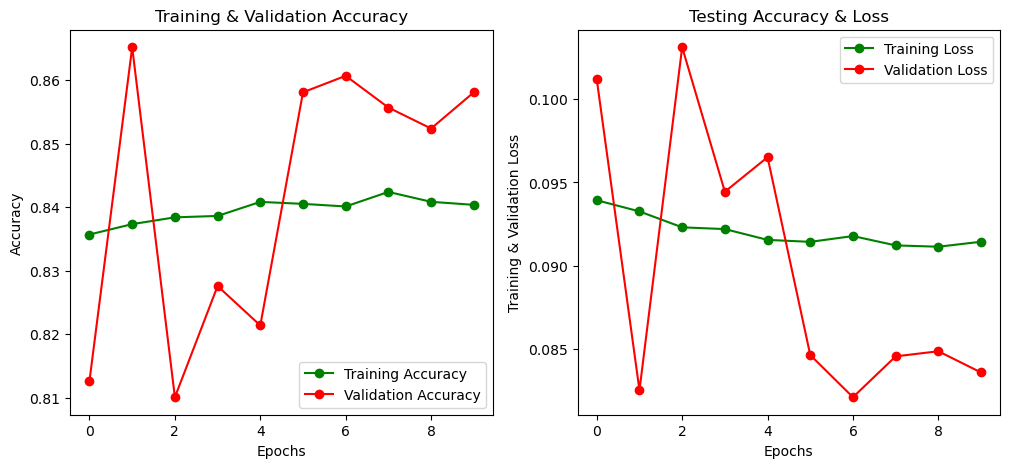

In [55]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2, figsize = (12, 5))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

plt.show()

225/225 [==============================] - 2s 9ms/step


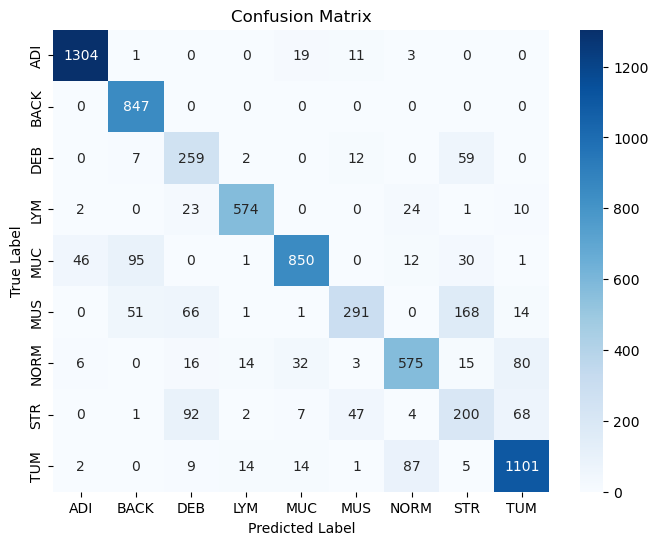

In [56]:
predictions = model.predict(x_test1)
predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to categorical
y_true_labels = np.argmax(y_test_one_hot, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [57]:
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

for i, class_name in enumerate(class_names):
    print(f"{class_name} Accuracy: {class_accuracy[i]*100:.4f}%")

ADI Accuracy: 97.4589%
BACK Accuracy: 100.0000%
DEB Accuracy: 76.4012%
LYM Accuracy: 90.5363%
MUC Accuracy: 82.1256%
MUS Accuracy: 49.1554%
NORM Accuracy: 77.5978%
STR Accuracy: 47.5059%
TUM Accuracy: 89.2944%


## Predict

In [58]:
def display_images_in_layout(images, original_labels, predicted_labels, class_names, num_columns, num_imgs):
    # Calculate the number of rows based on num_columns
    num_rows = int(num_imgs / num_columns)

    # Randomly generate index of shown images
    random_idx = np.random.choice(len(images), num_imgs, replace=False)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    # Loop through images and labels to display
    for i in range(len(random_idx)):
        row, col = divmod(i, num_columns)
        # Display image
        ax = axs[row, col]
        ax.imshow(images[random_idx[i]], cmap='gray')
        
        # Map numeric labels to class names
        original_label = class_names[int(original_labels[random_idx[i]])]
        predicted_label = class_names[int(predicted_labels[random_idx[i]])]
        title_color = 'green' if original_label == predicted_label else 'red'
        
        
        ax.set_title(f"Original: {original_label}\nPredicted: {predicted_label}", color = title_color)
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

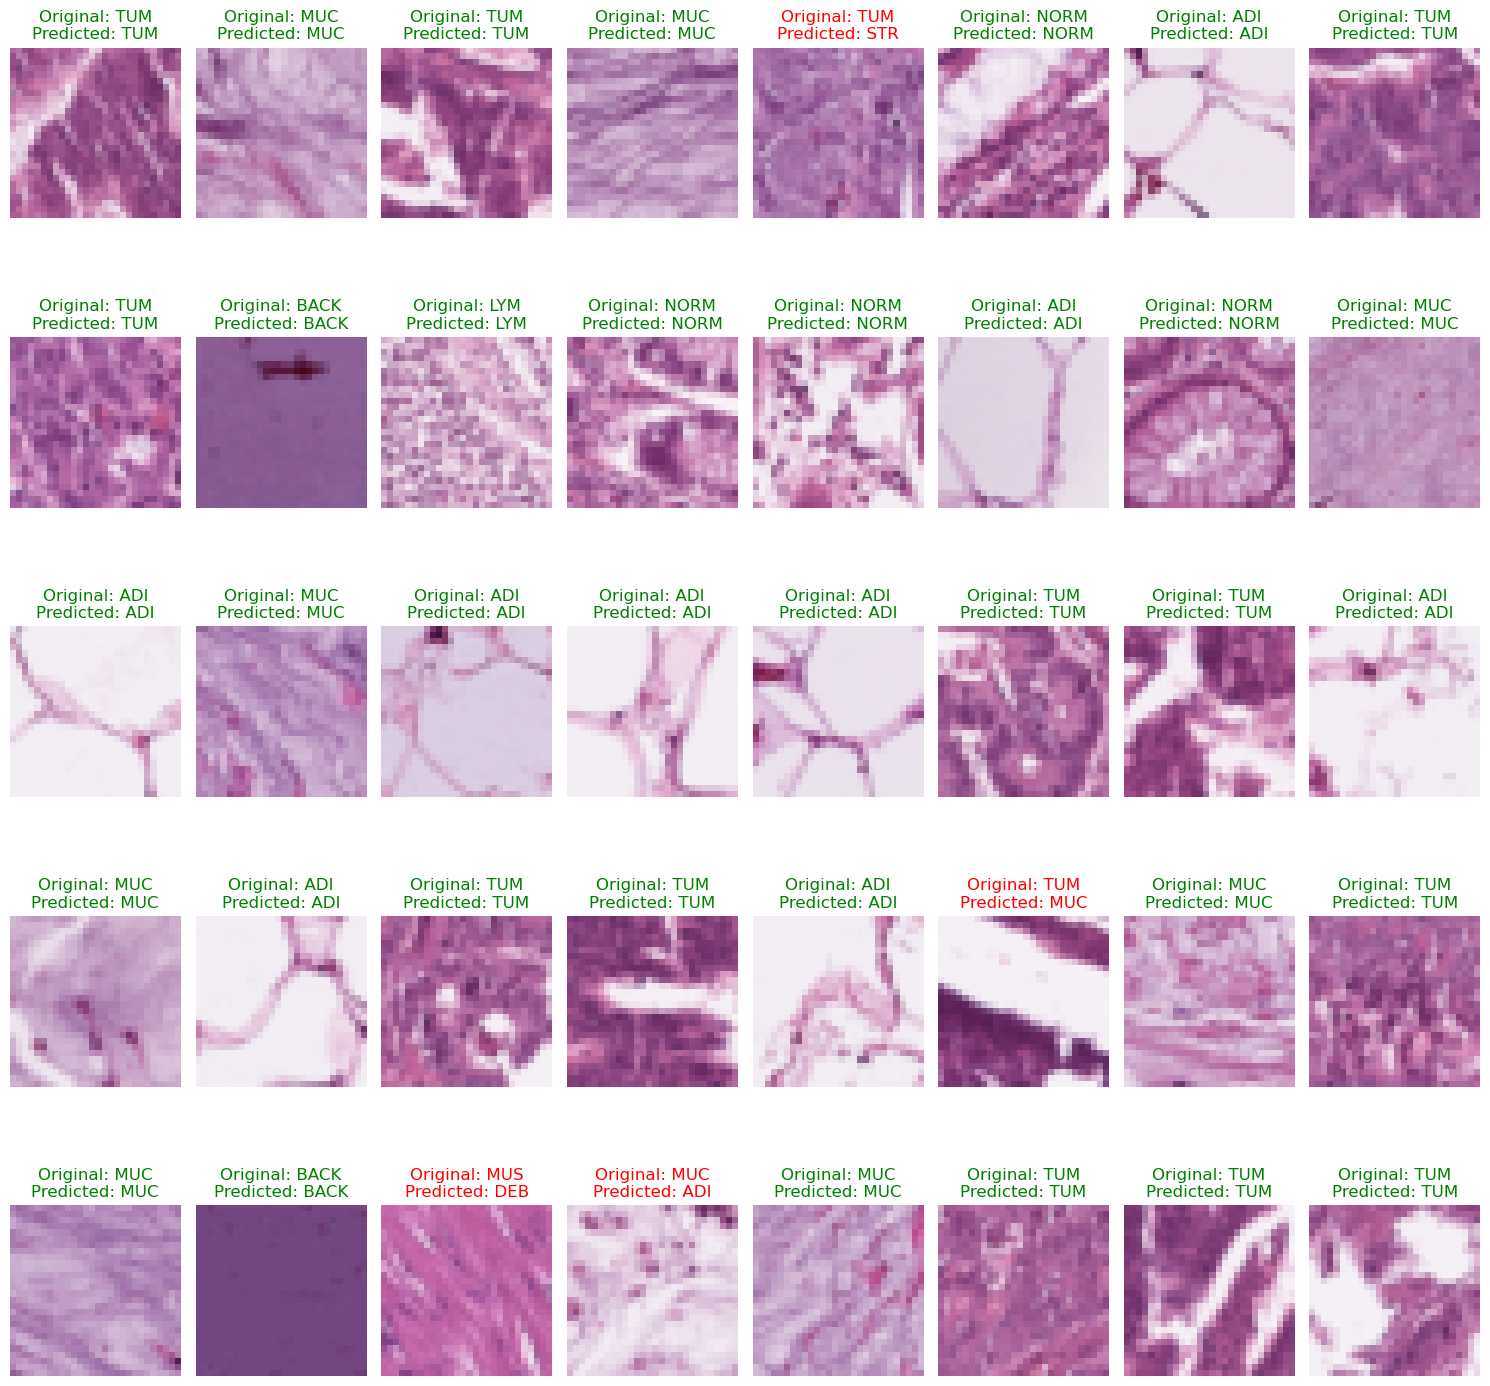

In [60]:
display_images_in_layout(x_test1, y_test, predicted_labels, class_names, 8, 40)